In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# Exploration

In [2]:
mytrain = 'ICE_692'
df = pd.read_csv(f'../data/trains/{mytrain}_delay.csv') #, index_col=0)
myroute = list(df.columns)
df.head()

,date,München Hbf,München-Pasing,Augsburg Hbf,Ulm Hbf,Stuttgart Hbf,Mannheim Hbf,Frankfurt(Main)Hbf,Fulda,Eisenach,Erfurt Hbf,Leipzig Hbf,Lutherstadt Wittenberg Hbf,Berlin Südkreuz,Berlin Hbf (tief),Berlin Gesundbrunnen
0,2019-01-01,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN
1,2019-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,0.0,4.0,1.0,1.0,1.0
2,2019-01-03,NaN,NaN,NaN,NaN,3.0,1.0,4.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-04,NaN,NaN,0.0,0.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-05,NaN,NaN,0.0,2.0,4.0,3.0,4.0,6.0,3.0,2.0,2.0,0.0,0.0,0.0,2.0


In [3]:
#plt.figure(figsize=(20,20))
#sns.heatmap(df, cbar=True, vmax=120)

# melting

In [4]:
df = df.melt(id_vars='date', var_name='station', value_name='delay')
df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)
df

,date,station,delay
0,2019-01-12,München Hbf,5.0
1,2019-01-25,München Hbf,0.0
2,2019-02-04,München Hbf,0.0
3,2019-02-06,München Hbf,0.0
4,2019-02-07,München Hbf,5.0
...,...,...,...
11733,2021-09-08,Berlin Gesundbrunnen,0.0
11734,2021-09-09,Berlin Gesundbrunnen,0.0
11735,2021-09-10,Berlin Gesundbrunnen,0.0
11736,2021-09-11,Berlin Gesundbrunnen,19.0


# feature engineering

In [5]:
df['date']= pd.to_datetime(df.date)
df['day'] = df.date.dt.day_name()
df['month'] = df.date.dt.month_name()
df.tail()

,date,station,delay,day,month
11733,2021-09-08,Berlin Gesundbrunnen,0.0,Wednesday,September
11734,2021-09-09,Berlin Gesundbrunnen,0.0,Thursday,September
11735,2021-09-10,Berlin Gesundbrunnen,0.0,Friday,September
11736,2021-09-11,Berlin Gesundbrunnen,19.0,Saturday,September
11737,2021-09-12,Berlin Gesundbrunnen,2.0,Sunday,September


In [6]:
from sklearn.preprocessing import OneHotEncoder
ohc = OneHotEncoder(sparse=False, handle_unknown='ignore', dtype=int)

In [7]:
df_stations = pd.DataFrame(ohc.fit_transform(df[['station']]))
df_stations.columns = ohc.get_feature_names([''])

In [8]:
df_days = pd.DataFrame(ohc.fit_transform(df[['day']]))
df_days.columns = ohc.get_feature_names([''])

In [9]:
df_months = pd.DataFrame(ohc.fit_transform(df[['month']]))
df_months.columns = ohc.get_feature_names([''])

In [10]:
df_enc = pd.concat([df, df_stations, df_days, df_months], axis=1)
df_enc.drop(['day', 'month'], axis=1, inplace=True)
df_enc.columns

Index(['date', 'station', 'delay', '_Augsburg Hbf', '_Berlin Gesundbrunnen',
       '_Berlin Hbf (tief)', '_Berlin Südkreuz', '_Eisenach', '_Erfurt Hbf',
       '_Frankfurt(Main)Hbf', '_Fulda', '_Leipzig Hbf',
       '_Lutherstadt Wittenberg Hbf', '_Mannheim Hbf', '_München Hbf',
       '_München-Pasing', '_Stuttgart Hbf', '_Ulm Hbf', '_Friday', '_Monday',
       '_Saturday', '_Sunday', '_Thursday', '_Tuesday', '_Wednesday', '_April',
       '_August', '_December', '_February', '_January', '_July', '_June',
       '_March', '_May', '_November', '_October', '_September'],
      dtype='object')

# train-test-split

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [12]:
X = df_enc.drop(['delay', 'date', 'station'], axis=1)
y = df_enc['delay']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9390, 34), (2348, 34), (9390,), (2348,))

# linear regression

In [13]:
mlr = LinearRegression()
mlr.fit(X_train, y_train)

LinearRegression()

In [14]:
y_train_pred_lr = mlr.predict(X_train)
y_test_pred_lr = mlr.predict(X_test)
print('train data mean absolute error:', round(mean_absolute_error(y_train, y_train_pred_lr), 2))
print('test_ data mean absolute error:', round(mean_absolute_error(y_test, y_test_pred_lr), 2))

train data mean absolute error: 7.36
test_ data mean absolute error: 7.41


# random forest

In [15]:
mrf = RandomForestRegressor(max_depth=8, bootstrap=True)
mrf.fit(X_train, y_train)

RandomForestRegressor(max_depth=8)

In [16]:
y_train_pred_rf = mrf.predict(X_train)
y_test_pred_rf = mrf.predict(X_test)
print('train data mean absolute error:', round(mean_absolute_error(y_train, y_train_pred_rf), 2))
print('test_ data mean absolute error:', round(mean_absolute_error(y_test, y_test_pred_rf), 2))

train data mean absolute error: 7.2
test_ data mean absolute error: 7.23


# visualization

In [17]:
df_enc['linreg'] = mlr.predict(X)
df_enc['ranfor'] = mrf.predict(X)

<ipython-input-18-03aa40d65aa0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub['mean'] = df_sub['delay'].mean()


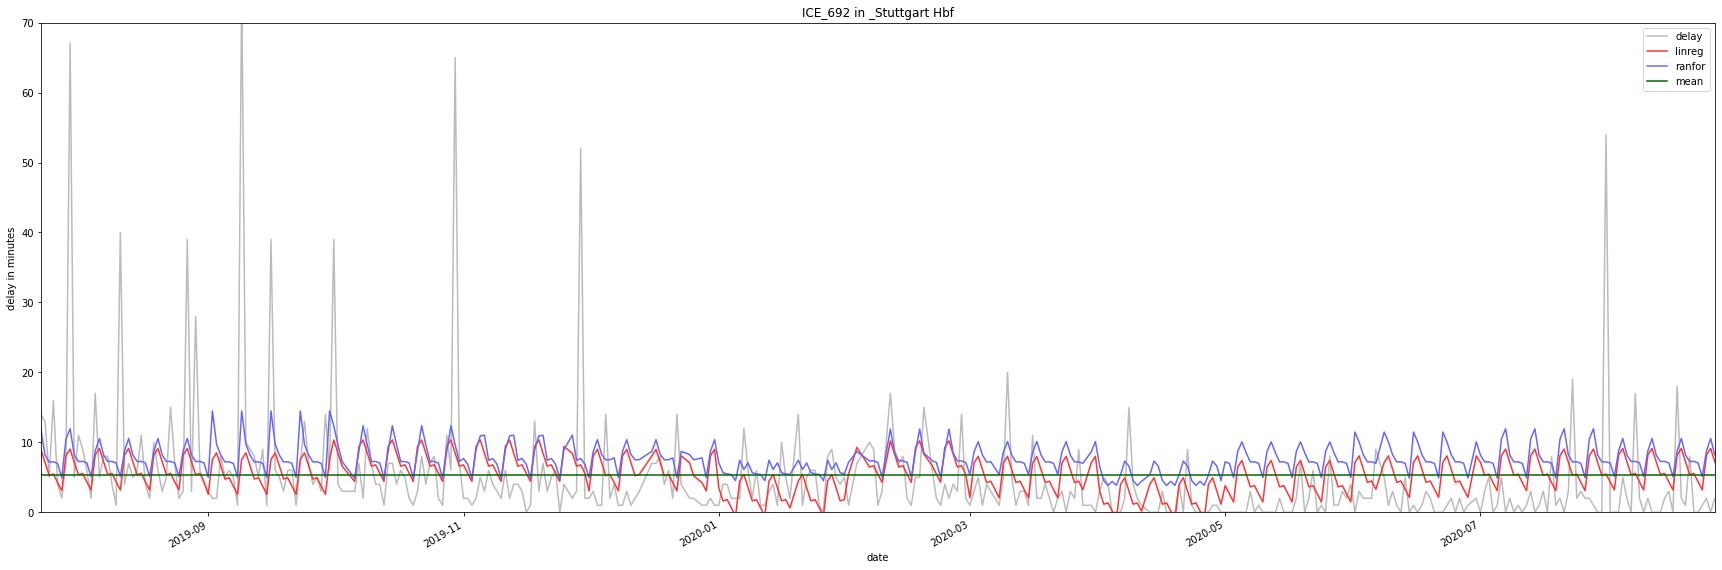

<Figure size 2160x720 with 0 Axes>

In [18]:
mystation = '_Stuttgart Hbf'
df_sub = df_enc.loc[df_enc[mystation] == 1]
df_sub['mean'] = df_sub['delay'].mean()

#sns.lineplot(data=df_sub, x='date', y='delay', legend='auto')
#sns.lineplot(data=df_sub, x='date', y='linreg', legend='auto')
#sns.lineplot(data=df_sub, x='date', y='ranfor', legend='auto')
df_sub.plot(x='date', y=['delay', 'linreg', 'ranfor', 'mean'], figsize=(30,10), color = ['#bbbbbb', '#ff3333', '#6666ff', '#006600'])

plt.xlim(18100, 18500)
plt.ylim(0, 70)
plt.ylabel('delay in minutes')
plt.title(f'{mytrain} in {mystation}')
plt.figure(figsize=(30,10))
#sns.despine()
plt.show()